# Cluster features using unsupervised learning
- Requires 'data/handlabeled_vectors_1k.csv'), with columns:
    - [0] is old index, ignore.
    - [1] is id 
    - [2] is original category
    - [3] is hand category
    - [next 300] are text features
    - [next 300] are image features

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import itertools

# Import data

In [2]:
df = pd.read_csv('data/handlabeled_vectors_1k.csv')
id_vec = df[df.columns[1]]
category_vec = df[df.columns[3]]
text_vec = df[df.columns[4:304]]
image_vec = df[df.columns[304:604]]
combined_vec = df[df.columns[4:604]]

## Unsupervised Clustering with K-Means
- First pass uses 11 categories just to compare to client's existing categories.
- In the future, use hierarchical to discover appropriate number of categories or elbow method

In [3]:
# Perform clustering on image + text, as that showed good results in supervised learning
y = category_vec
X = combined_vec
kmeans = KMeans(n_clusters=11, random_state=0).fit(X)
kmeans_pred = kmeans.labels_

In [4]:
# Try just image
im_y = image_vec
X = combined_vec
im_kmeans = KMeans(n_clusters=11, random_state=0).fit(X)
im_kmeans_pred = im_kmeans.labels_

In [5]:
# Try just text
tx_y = text_vec
X = combined_vec
tx_kmeans = KMeans(n_clusters=11, random_state=0).fit(X)
tx_kmeans_pred = tx_kmeans.labels_

## Validate clustering

### Clustering metrics
On emergent categories on combined data

In [49]:
X = combined_vec
y = kmeans_pred

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)
    
# Compare similarity between two labeling schemes. 0 is random, 1 is identical groupings.
print('Adjusted Rand index: ' + str(metrics.adjusted_rand_score(y_test, lr_y_pred)))

# Measure the agreement of the two assignments, ignoring permutations
print('Adjusted mutual information: ' + str(metrics.adjusted_mutual_info_score(y_test, lr_y_pred)))

# Homogeneity: Each cluster contains only members of a single class
print('Homogeneity score: ' + str(metrics.homogeneity_score(y_test, lr_y_pred)))

# Completeness: All members of a given class are assigned to the same cluster
print('Completeness score: ' + str(metrics.completeness_score(y_test, lr_y_pred)))

# "V-measure", aka harmonic mean
print('V-Measure: ' + str(metrics.v_measure_score(y_test, lr_y_pred)))

# Fowlkes-Mallows score: is the geometric mean of the pairwise precision and recall
print('FMI: ' + str(metrics.fowlkes_mallows_score(y_test, lr_y_pred)))


Adjusted Rand index: 0.854588122974
Adjusted mutual information: 0.857360805779
Homogeneity score: 0.858484755222
Completeness score: 0.859479217662
V-Measure: 0.858981698614
FMI: 0.869330144357


### But do we make classification accuracy better? That's the client's real goal.

In [9]:
def do_logreg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
    lr = LogisticRegression(random_state=1)
    lr.fit(X_train, y_train)
    lr_y_pred = lr.predict(X_test)
    return(accuracy_score(y_test, lr_y_pred))


#### For text + image

In [13]:
# For Text + Image
X = combined_vec
y = category_vec
y_emer = kmeans_pred = kmeans.labels_

# Logistic regression results with emergent categories
print('Accuracy on original = ' + str(do_logreg(X,y)))

# and with emergent categories:
print('Accuracy on emergent = ' + str(do_logreg(X,y_emer)))

Accuracy on original = 0.821454545455
Accuracy on emergent = 0.933090909091


#### For image only

In [14]:
# For Image
X = image_vec
y = category_vec
y_emer = kmeans_pred = kmeans.labels_

# Logistic regression results with emergent categories
print('Accuracy on original = ' + str(do_logreg(X,y)))

# and with emergent categories:
print('Accuracy on emergent = ' + str(do_logreg(X,y_emer)))

Accuracy on original = 0.766181818182
Accuracy on emergent = 0.934909090909


#### For text only

In [15]:
# For Text
X = text_vec
y = category_vec
y_emer = kmeans_pred = kmeans.labels_

# Logistic regression results with emergent categories
print('Accuracy on original = ' + str(do_logreg(X,y)))

# and with emergent categories:
print('Accuracy on emergent = ' + str(do_logreg(X,y_emer)))

Accuracy on original = 0.816363636364
Accuracy on emergent = 0.631272727273


## Visualize with PCA embedding
Embed data in 2D and color with labels
- Consider check Hopkin's statistic: is the data uniformly distributed? Is it even clusterable?

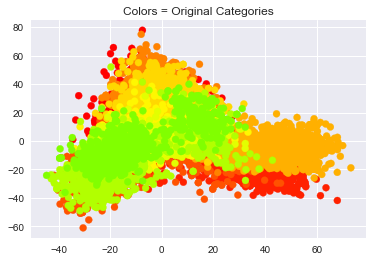

In [21]:
X = combined_vec
y = category_vec

pca_embed = PCA(n_components=2,random_state=0).fit_transform(X)
colors = pd.factorize(y)
plt.scatter(pca_embed[:,0], pca_embed[:,1], color=cm.prism(colors[0])) 
plt.title('Colors = Original Categories')

### Plot subset of data with PCA labels for easier visualization

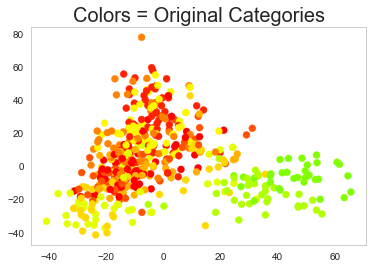

In [36]:
pcawithlabels = np.hstack((pca_embed, np.reshape(np.array(pd.factorize(category_vec)[0]),
                                                 newshape=(11000,1)),
                           np.reshape(kmeans_pred, newshape=(11000,1)) ))

A = pcawithlabels
A = A[np.random.randint(A.shape[0], size=500), :]
colors = pd.factorize(A[:,2])
plt.scatter(A[:,0], A[:,1], color=cm.prism(colors[0])) 
plt.title('Colors = Original Categories', size=20)

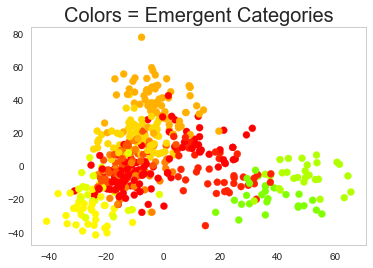

In [37]:

kmcolors = pd.factorize(A[:,3])
plt.scatter(A[:,0], A[:,1], color=cm.prism(kmcolors[0]))
plt.title('Colors = Emergent Categories', size=20)

### Generate graphs with new colors, easier to visualize

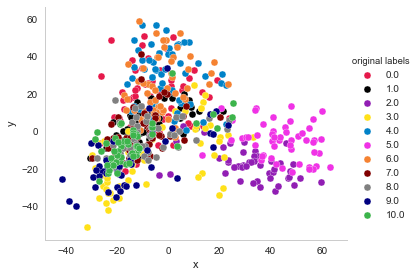

In [40]:
A = pcawithlabels
A = A[np.random.randint(A.shape[0], size=600), :]
Adf = pd.DataFrame(A)
Adf.columns = ('x', 'y', 'original labels', 'kmeans labels')
#flatui = ["#9b59b6", "#00ff00", "#95a5a6", "#3498db", "#34495e", "#2ecc71",
#          "#e7298a","#0000FF","#000000","#FFE135","#ff7f00"]
jcolors = ["#e6194b", #red
           "#000000", #black 
           "#911eb4", #purple
           "#ffe119", #yellow
           "#0082c8", #blue
           "#f032e6", #magenta
           "#f58231", #orange
           "#800000", #maroon
           "#808080", #gray
           "#000080", #navy
           "#3cb44b"] #green
current_palette = sns.color_palette(jcolors)
#current_palette = sns.color_palette("plasma", 11)
sns.set_palette(current_palette)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(x_vars=["x"], y_vars=["y"], data=Adf, hue="original labels", size=4, aspect = 1.25)

In [41]:
factorindex = pd.factorize(category_vec)

# Index for what categories are (commented out for NDA)
#for i in range(0,11):
    #print(str(i) + '. '+ factorindex[1][i])

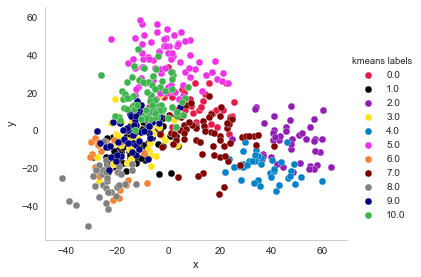

In [42]:
# Plot emergent categories
sns.pairplot(x_vars=["x"], y_vars=["y"], data=Adf, hue="kmeans labels", size=4, aspect=1.25)